<a href="https://colab.research.google.com/github/avoy-mollick-bd/CVPR/blob/main/Mid/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup & Imports




In [151]:
import os#avoy
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


2. Load Dataset

In [152]:
#from google.colab import files
#uploaded = files.upload()


3.Unzip The Loaded Dataset

In [153]:
'''import zipfile
import io

zip_ref = zipfile.ZipFile(io.BytesIO(uploaded["data.zip"]), 'r')
zip_ref.extractall("/content")
zip_ref.close()'''

'import zipfile\nimport io\n\nzip_ref = zipfile.ZipFile(io.BytesIO(uploaded["data.zip"]), \'r\')\nzip_ref.extractall("/content")\nzip_ref.close()'

4. Load + Convert to Grayscale + Resize + Flatten


In [154]:
data_path = "/content/data"

classes = ["cat", "dog", "panda"]
label_map = {"cat":0, "dog":1, "panda":2}

X = []
y = []

for cls in classes:
    folder = os.path.join(data_path, cls)#avoy
    for img_name in tqdm(os.listdir(folder), desc=f"Loading {cls}"):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).resize((32, 32))
            arr_rgb = np.array(img)

            R = arr_rgb[:, :, 0]
            G = arr_rgb[:, :, 1]
            B = arr_rgb[:, :, 2]

            gray = (0.299*R + 0.587*G + 0.114*B).astype(np.uint8)

            arr = gray.flatten()

            X.append(arr)
            y.append(label_map[cls])#avoy
        except:
            pass

X = np.array(X)
y = np.array(y)

print("Dataset Loaded:", X.shape, y.shape)


Loading panda: 100%|██████████| 100/100 [00:00<00:00, 236.11it/s]

Dataset Loaded: (299, 1024) (299,)


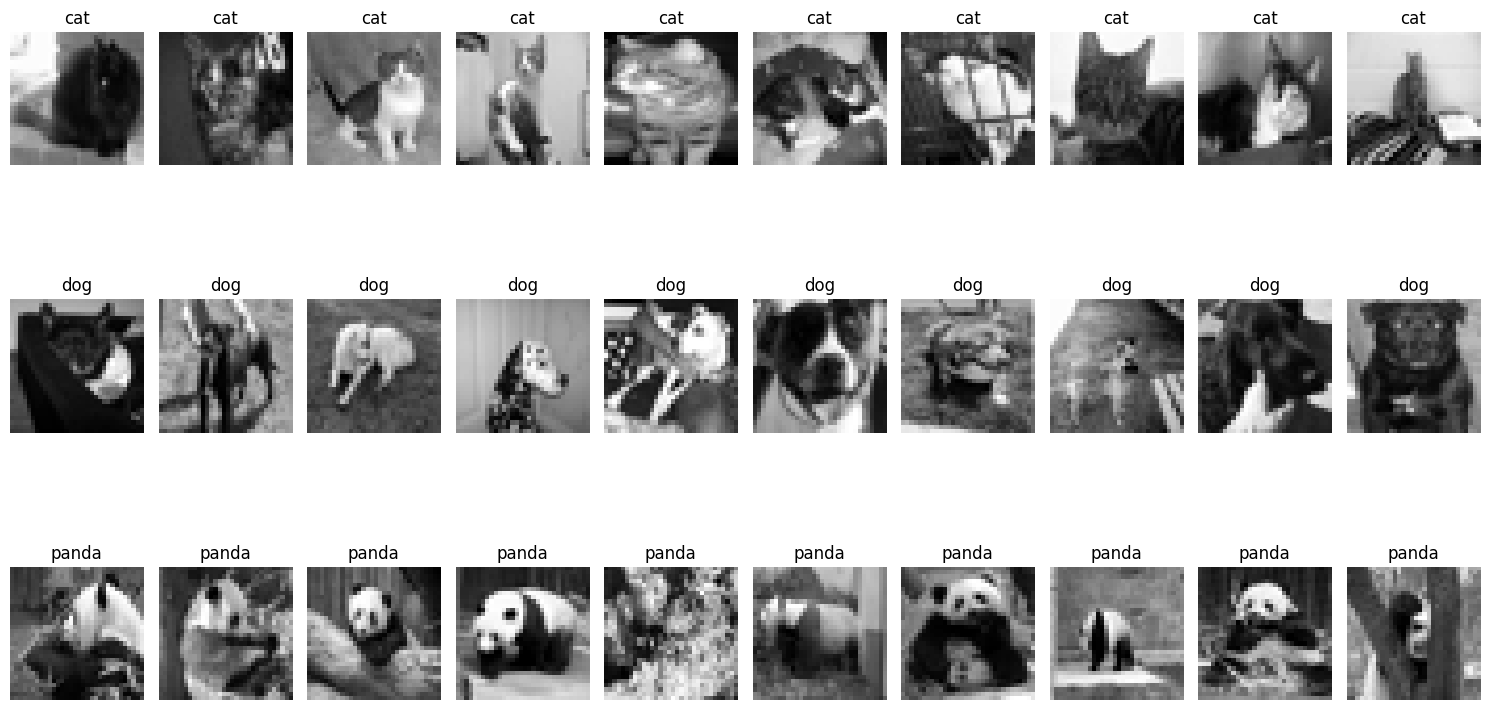

In [155]:
plt.figure(figsize=(15, 9))

images_per_class = 10
start_index = 1

for class_index, class_name in enumerate(classes):

    class_indices = np.where(y == class_index)[0]
    selected = np.random.choice(class_indices, images_per_class, replace=False)

    for j, idx in enumerate(selected):
        img = X[idx].reshape(32, 32)

        plt.subplot(len(classes), images_per_class, start_index)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
        start_index += 1

plt.tight_layout()
plt.show()

5.Shuffle Dataset

In [156]:
idx = np.arange(len(X))
np.random.shuffle(idx)

X = X[idx]
y = y[idx]


6.Split into 5 folds

5-folds created.


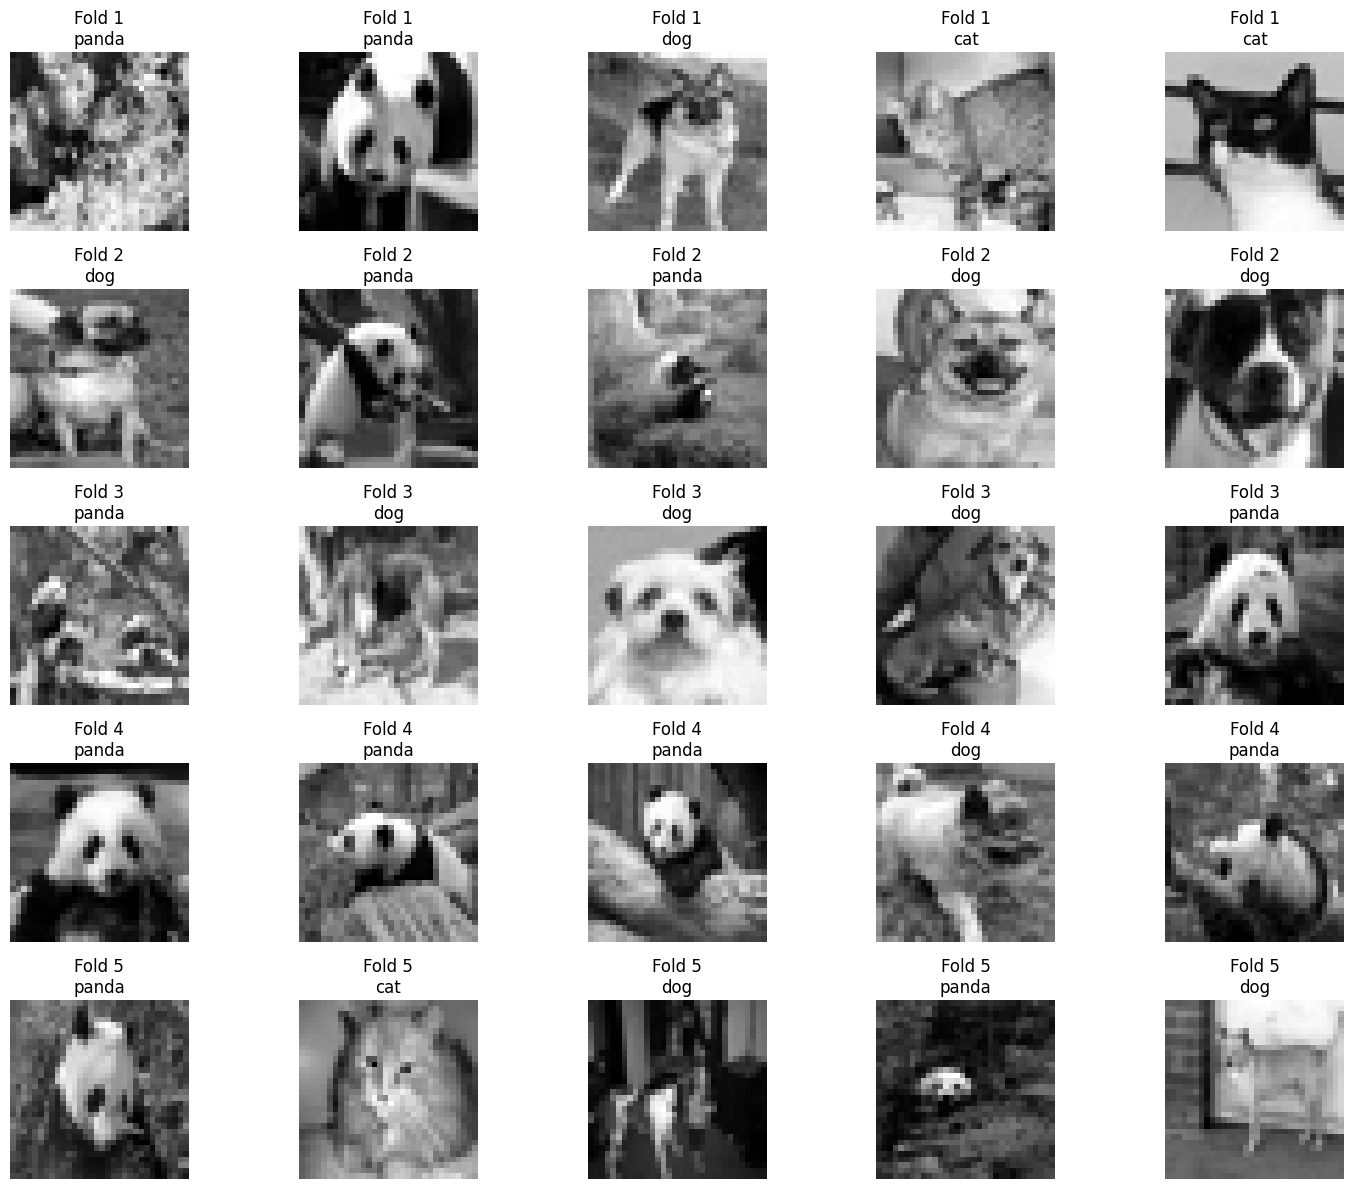

In [157]:
def create_folds(X, y, k=5):
    fold_size = len(X) // k
    folds_X = []
    folds_y = []

    for i in range(k):
        folds_X.append(X[i*fold_size:(i+1)*fold_size])
        folds_y.append(y[i*fold_size:(i+1)*fold_size])

    return folds_X, folds_y

folds_X, folds_y = create_folds(X, y)
print("5-folds created.")

plt.figure(figsize=(15, 12))

samples_per_fold = 5

for fold_idx in range(5):
    for i in range(samples_per_fold):

        idx = np.random.randint(0, len(folds_X[fold_idx]))
        img = folds_X[fold_idx][idx].reshape(32, 32)
        label = folds_y[fold_idx][idx]

        plt.subplot(5, samples_per_fold, fold_idx * samples_per_fold + i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Fold {fold_idx+1}\n{classes[label]}")
        plt.axis("off")

plt.tight_layout()
plt.show()



7.Distance Functions (L1 & L2)

In [158]:
def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))


8.KNN Implementation

In [159]:
def predict_knn(train_X, train_y, test_sample, K, distance_type="L1"):
    distances = []

    for i in range(len(train_X)):
        if distance_type == "L1":
            dist = manhattan_distance(test_sample, train_X[i])
        else:
            dist = euclidean_distance(test_sample, train_X[i])
        distances.append((dist, train_y[i]))

    distances = sorted(distances, key=lambda x: x[0])

    k_labels = [label for _, label in distances[:K]]
    counts = np.bincount(k_labels)
    return np.argmax(counts)


9. Evaluate Accuracy for One Fold

In [160]:
def evaluate_fold(train_X, train_y, test_X, test_y, K, distance_type):
    correct = 0
    for i in range(len(test_X)):
        pred = predict_knn(train_X, train_y, test_X[i], K, distance_type)
        if pred == test_y[i]:
            correct += 1
    return correct / len(test_y)#avoy


10. Evaluate All K Values Across All Folds

In [161]:
K_values = [1, 3, 5, 7, 9 , 11, 13 , 15]

results_L1 = []
results_L2 = []

print("   FOLD-WISE ACCURACY TABLE")

for K in K_values:
    print(f"\n---------- K = {K} ----------")

    fold_acc_L1 = []
    fold_acc_L2 = []

    for i in range(5):

        print(f"\nFold {i+1}:")

        test_X = folds_X[i]
        test_y = folds_y[i]

        train_X = np.vstack([folds_X[j] for j in range(5) if j != i])
        train_y = np.hstack([folds_y[j] for j in range(5) if j != i])

        acc_L1 = evaluate_fold(train_X, train_y, test_X, test_y, K, "L1")
        acc_L2 = evaluate_fold(train_X, train_y, test_X, test_y, K, "L2")

        fold_acc_L1.append(acc_L1)#avoy
        fold_acc_L2.append(acc_L2)

        print(f"   L1 Accuracy = {acc_L1:.2f}%")
        print(f"   L2 Accuracy = {acc_L2:.2f}%")

    mean_L1 = np.mean(fold_acc_L1)
    mean_L2 = np.mean(fold_acc_L2)

    results_L1.append(mean_L1)
    results_L2.append(mean_L2)

    print(f"\n>>> Average L1 Accuracy for K={K}: {mean_L1:.2f}%")
    print(f">>> Average L2 Accuracy for K={K}: {mean_L2:.2f}%")
    print("---------------------------------------------")

print("\nFINAL MEAN RESULTS")
print("------------------------------")
print("L1 Mean Accuracies:", results_L1)
print("L2 Mean Accuracies:", results_L2)


   FOLD-WISE ACCURACY TABLE

---------- K = 1 ----------

Fold 1:
   L1 Accuracy = 0.46%
   L2 Accuracy = 0.39%

Fold 2:
   L1 Accuracy = 0.39%
   L2 Accuracy = 0.24%

Fold 3:
   L1 Accuracy = 0.31%
   L2 Accuracy = 0.25%

Fold 4:
   L1 Accuracy = 0.47%
   L2 Accuracy = 0.47%

Fold 5:
   L1 Accuracy = 0.42%
   L2 Accuracy = 0.37%

>>> Average L1 Accuracy for K=1: 0.41%
>>> Average L2 Accuracy for K=1: 0.35%
---------------------------------------------

---------- K = 3 ----------

Fold 1:
   L1 Accuracy = 0.39%
   L2 Accuracy = 0.36%

Fold 2:
   L1 Accuracy = 0.42%
   L2 Accuracy = 0.22%

Fold 3:
   L1 Accuracy = 0.31%
   L2 Accuracy = 0.27%

Fold 4:
   L1 Accuracy = 0.44%
   L2 Accuracy = 0.31%

Fold 5:
   L1 Accuracy = 0.46%
   L2 Accuracy = 0.41%

>>> Average L1 Accuracy for K=3: 0.40%
>>> Average L2 Accuracy for K=3: 0.31%
---------------------------------------------

---------- K = 5 ----------

Fold 1:
   L1 Accuracy = 0.42%
   L2 Accuracy = 0.31%

Fold 2:
   L1 Accuracy = 0.42

# **Discussion**

In [162]:
def discussion(k_values, acc_l1, acc_l2):
    best_k_l1 = k_values[np.argmax(acc_l1)]
    best_acc_l1 = max(acc_l1)

    best_k_l2 = k_values[np.argmax(acc_l2)]
    best_acc_l2 = max(acc_l2)

    s = []
    s.append("Results summary:")
    s.append(f" - Best L1 (Manhattan) accuracy = {best_acc_l1:.3f} at K = {best_k_l1}")
    s.append(f" - Best L2 (Euclidean) accuracy = {best_acc_l2:.3f} at K = {best_k_l2}")
    s.append("")

    return "\n".join(s)


print(discussion(K_values, results_L1, results_L2))


Results summary:
 - Best L1 (Manhattan) accuracy = 0.424 at K = 5
 - Best L2 (Euclidean) accuracy = 0.380 at K = 15



11. Plot Accuracy vs K

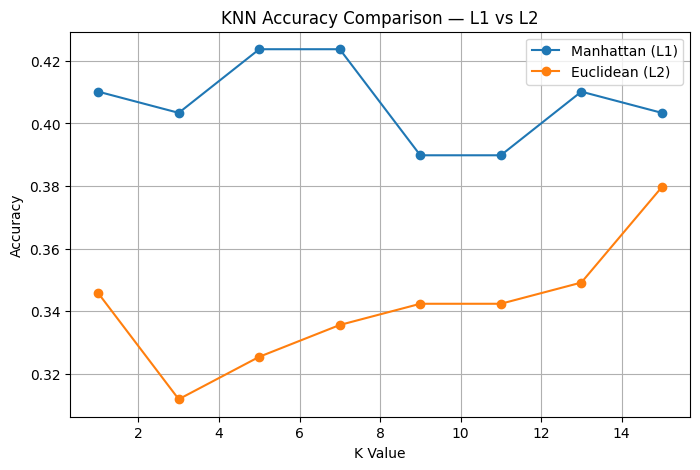

In [163]:
plt.figure(figsize=(8,5))
plt.plot(K_values, results_L1, marker='o', label="Manhattan (L1)")
plt.plot(K_values, results_L2, marker='o', label="Euclidean (L2)")

plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy Comparison — L1 vs L2")
plt.legend()
plt.grid(True)
plt.show()


# 13. Show Top 5 Predictions

Top 5 Predictions (L1 & L2):



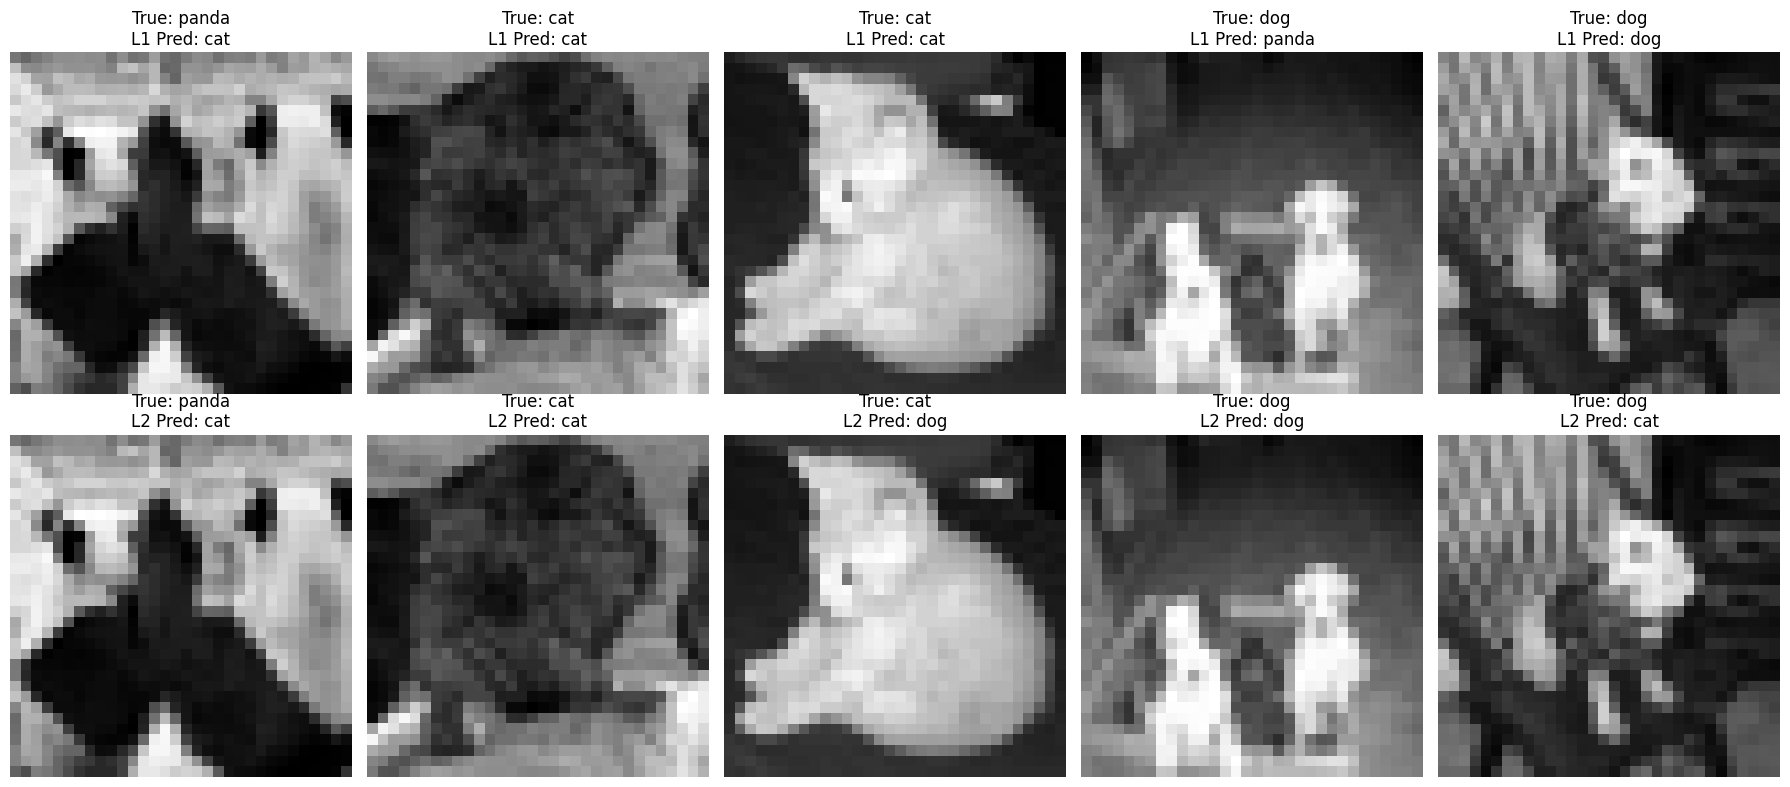


Accuracy (L1): 3/5 = 60.00%
Accuracy (L2): 2/5 = 40.00%


In [165]:
total = 5

correct_L1 = 0
correct_L2 = 0

plt.figure(figsize=(18, 8))

print("Top 5 Predictions (L1 & L2):\n")

for i in range(total):

    idx = random.randint(0, len(X)-1)
    img = X[idx]
    true_label = y[idx]

    pred_L1 = predict_knn(X, y, img, K=3, distance_type="L1")
    pred_L2 = predict_knn(X, y, img, K=3, distance_type="L2")

    if pred_L1 == true_label:
        correct_L1 += 1

    if pred_L2 == true_label:
        correct_L2 += 1

    plt.subplot(2, total, i+1)
    plt.imshow(img.reshape(32, 32), cmap="gray")#avoy
    plt.title(
        f"True: {classes[true_label]}\nL1 Pred: {classes[pred_L1]}"
    )
    plt.axis("off")

    plt.subplot(2, total, total+i+1)
    plt.imshow(img.reshape(32, 32), cmap="gray")
    plt.title(
        f"True: {classes[true_label]}\nL2 Pred: {classes[pred_L2]}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

# Accuracy
acc_L1 = (correct_L1 / total) * 100
acc_L2 = (correct_L2 / total) * 100

print(f"\nAccuracy (L1): {correct_L1}/{total} = {acc_L1:.2f}%")
print(f"Accuracy (L2): {correct_L2}/{total} = {acc_L2:.2f}%")
